# Problem: Forecasting Stock Prices using Time Series Modeling

## Method: ARIMA
## Data: Stock market prices from Investing.com
## Libraries:
- numpy
- pandas
- statsmodels
- matplotlib
- scikit-learn (sklearn)
- scipy
- itertools

## Import Libraries
We will be working with numpy, pandas, plotly, requests, and datetime

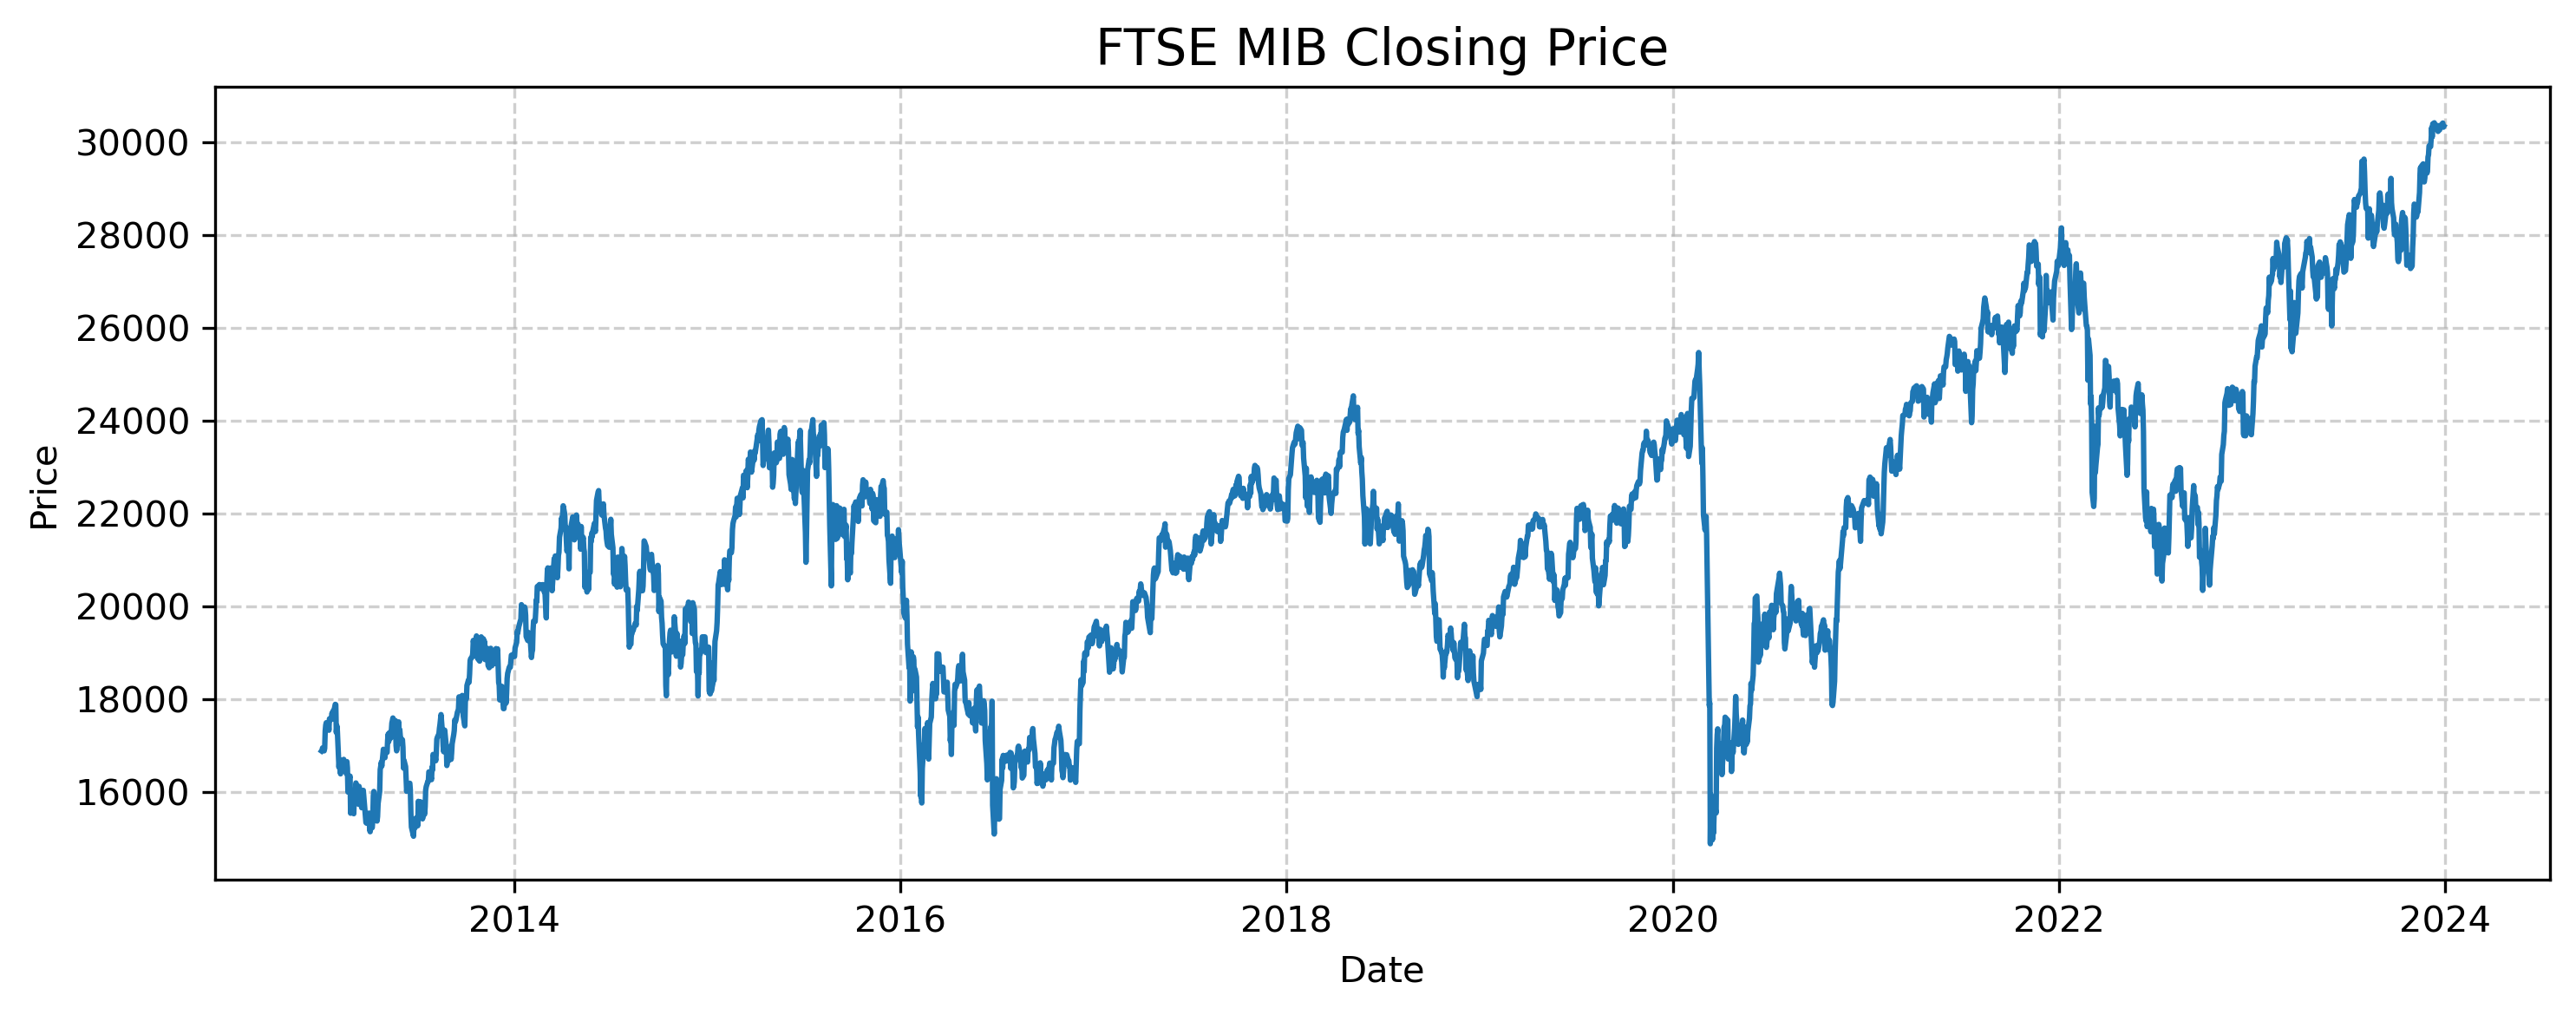

Dickey-Fuller p-value: 0.36568349158938457


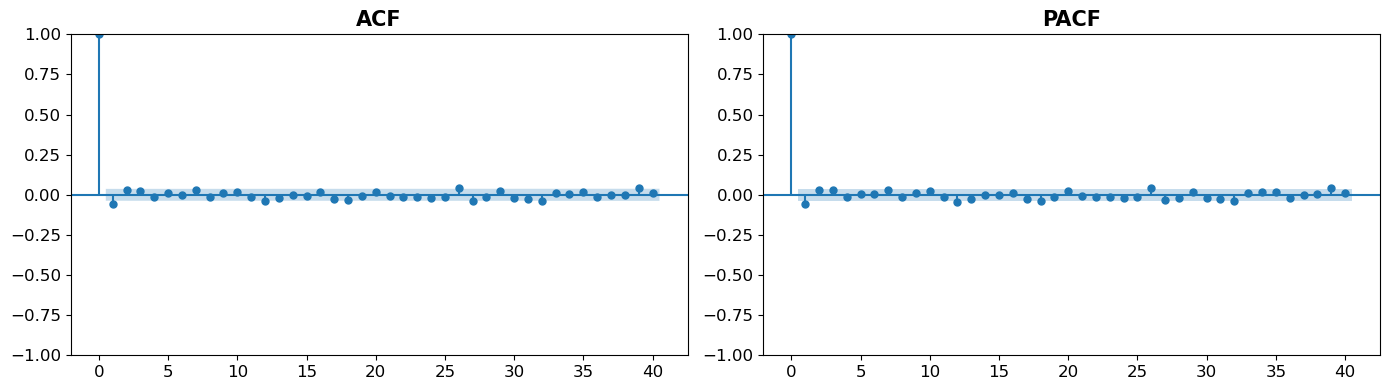

c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramet

Selected order: (2, 1, 2)


c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Walk-forward RMSEs: ['269.64', '302.30', '307.87']
Test RMSE: 323.79
Test MAE: 239.49
Test MAPE: 0.95%
Test R^2: 0.98
Residual mean: 7.3614
t-test p-value: 0.5904
Ljung-Box p-value (lag 10): 0.0074


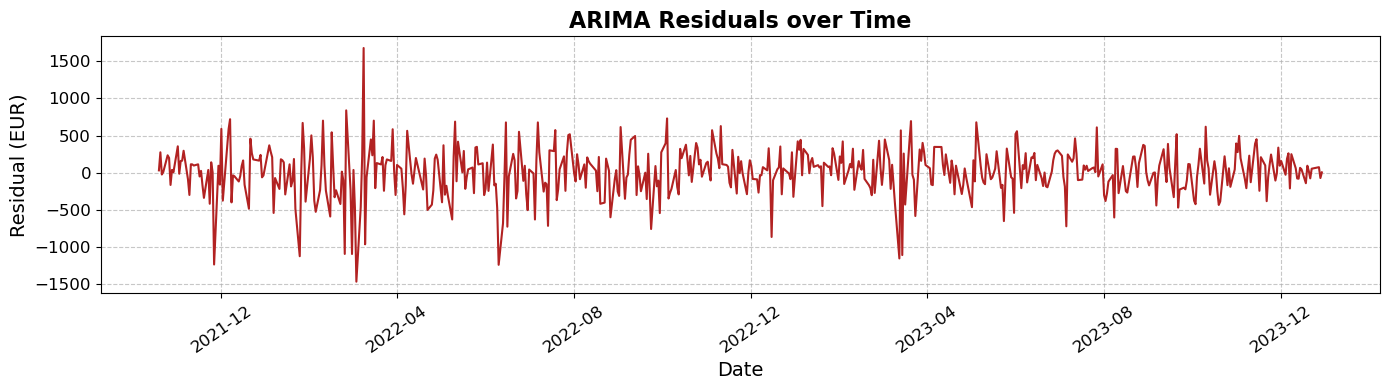

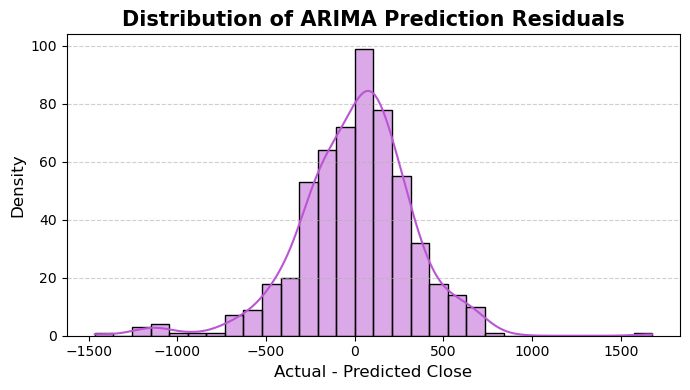

Ljung-Box p < 0.05, refitting with order (3, 1, 3)


c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test RMSE: 324.04
Test MAE: 239.52
Test MAPE: 0.95%
Test R^2: 0.98
Test Ljung-Box p-value: 0.0074


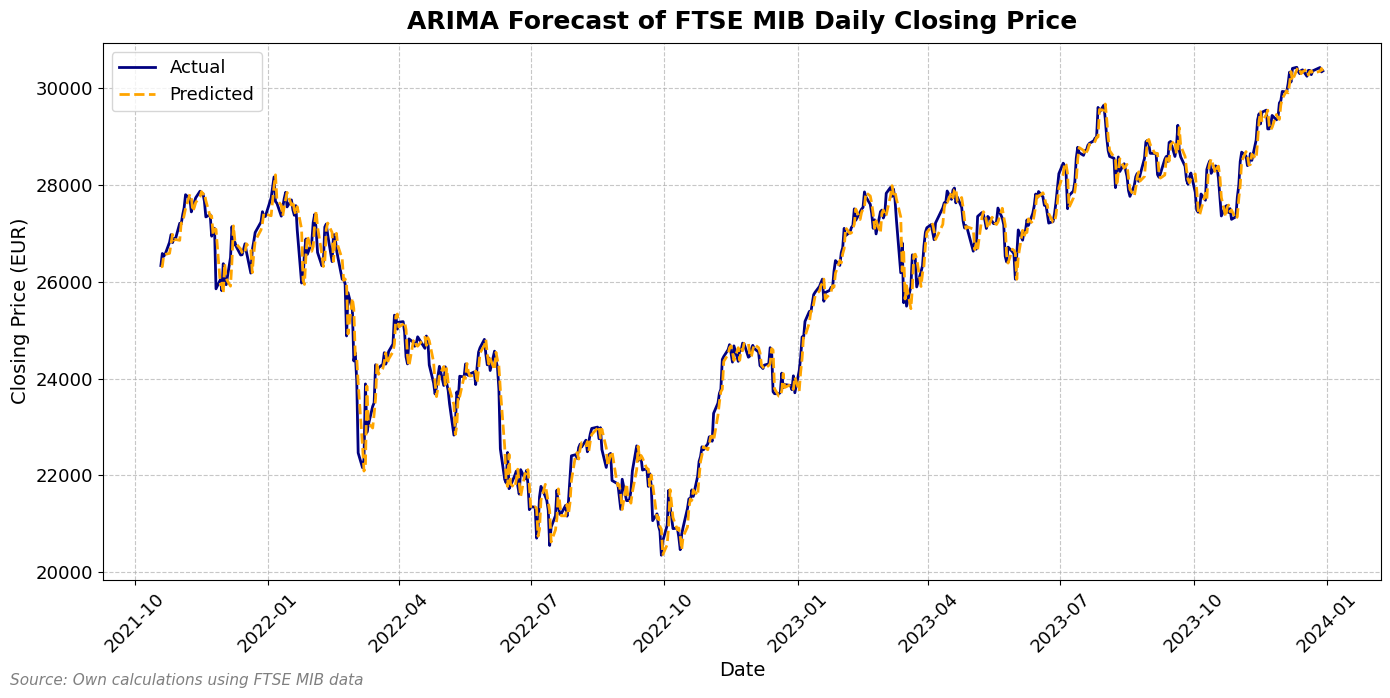

Next day predicted close: 30348.83


In [1]:
"""ARIMA forecasting of the FTSE MIB closing prices.

This script loads the dataset, cleans numeric columns, plots the series,
checks for stationarity with the Dickey-Fuller test, visualizes ACF and
PACF, then fits an ARIMA model selected via a simple grid search. It evaluates the
forecast on an 80/20 train-test split and saves plots of the data and
predictions.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
import itertools

# 1. Load data
file_path = "dataftsemib_manual.csv"

df = pd.read_csv(file_path)

# 2. Clean data
# Parse dates
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# Numeric columns with commas
num_cols = ["Price", "Open", "High", "Low"]
for col in num_cols:
    df[col] = df[col].str.replace(",", "")
    df[col] = df[col].astype(float)

# Volume column (M/B suffix)

def parse_volume(v: str) -> float:
    v = str(v).strip()
    if v.endswith("M"):
        return float(v[:-1].replace(",", "")) * 1e6
    if v.endswith("B"):
        return float(v[:-1].replace(",", "")) * 1e9
    return float(v.replace(",", ""))


df["Vol."] = df["Vol."].apply(parse_volume)

# Change percent column
change = df["Change %"].str.replace("%", "").str.replace(",", ".")
df["Change %"] = change.astype(float)

# Sort by date and reset index

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# 3. Plot the cleaned closing prices
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(df["Date"], df["Price"], color="tab:blue")
plt.title("FTSE MIB Closing Price", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("arima_cleaned_prices.png", dpi=300)
plt.show()
plt.close()

# 4. Stationarity check
result = adfuller(df["Price"])
print("Dickey-Fuller p-value:", result[1])

# 5. ACF and PACF of first-differenced series
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df["Price"].diff().dropna(), ax=axes[0], lags=40)
axes[0].set_title("ACF", fontsize=15, fontweight='bold')
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
plot_pacf(df["Price"].diff().dropna(), ax=axes[1], lags=40, method="ywm")
axes[1].set_title("PACF", fontsize=15, fontweight='bold')
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.savefig("arima_acf_pacf.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 6. Train/test split
prices = df["Price"]
split = int(len(prices) * 0.8)
train, test = prices[:split], prices[split:]

# 7. Search for a good (p,d,q) order using AIC
p = range(0, 6)
d = [0, 1]
q = range(0, 6)
best_aic = float("inf")
best_order = (1, 1, 1)
for order in itertools.product(p, d, q):
    try:
        model = ARIMA(train, order=order)
        result = model.fit()
        if result.aic < best_aic:
            best_aic = result.aic
            best_order = order
    except Exception:
        continue

print("Selected order:", best_order)

# Rolling/Walk-forward validation over multiple windows
tscv = TimeSeriesSplit(n_splits=3)
cv_rmse = []

def rolling_forecast(train_series, test_series, order):
    model_fit = ARIMA(train_series, order=order).fit()
    preds = []
    rolling = model_fit
    for obs in test_series:
        pred = rolling.forecast()
        preds.append(pred.iloc[0])
        rolling = rolling.append([obs], refit=False)
    return pd.Series(preds, index=test_series.index)

for cv_train_idx, cv_test_idx in tscv.split(prices):
    cv_train, cv_test = prices.iloc[cv_train_idx], prices.iloc[cv_test_idx]
    cv_pred = rolling_forecast(cv_train, cv_test, best_order)
    cv_rmse.append(np.sqrt(mean_squared_error(cv_test, cv_pred)))

print("Walk-forward RMSEs:", [f"{m:.2f}" for m in cv_rmse])

model_fit = ARIMA(train, order=best_order).fit()

# 8. Forecast on test set using a rolling one-step approach
# Update the fitted model with each new observation so forecasts respond
# to the latest values without drifting toward a constant.
forecast_vals = []
rolling_fit = model_fit
for obs in test:
    pred = rolling_fit.forecast()
    forecast_vals.append(pred.iloc[0])
    # incorporate the actual observation without re-estimating parameters
    rolling_fit = rolling_fit.append([obs], refit=False)
forecast = pd.Series(forecast_vals, index=test.index)

rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)
print(
    f"Test RMSE: {rmse:.2f}\n"
    f"Test MAE: {mae:.2f}\n"
    f"Test MAPE: {mape:.2%}\n"
    f"Test R^2: {r2:.2f}"
)

# 8b. Residual analysis for bias detection
residuals = test - forecast
# t-test for zero mean residuals (no bias)
t_stat, t_p = stats.ttest_1samp(residuals, 0.0)
# Ljung-Box test for autocorrelation up to lag 10
ljung = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(
    f"Residual mean: {residuals.mean():.4f}\n"
    f"t-test p-value: {t_p:.4f}\n"
    f"Ljung-Box p-value (lag 10): {ljung['lb_pvalue'].iloc[0]:.4f}"
)

plt.figure(figsize=(14, 4))
plt.plot(df["Date"].iloc[split:], residuals, color="firebrick", linewidth=1.5)
plt.title("ARIMA Residuals over Time", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Residual (EUR)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(fontsize=12, rotation=35)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("arima_residuals_over_time.png", dpi=300, bbox_inches='tight')
plt.show()
final_order = best_order

import seaborn as sns
plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=30, kde=True, color="mediumorchid")
plt.title("Distribution of ARIMA Prediction Residuals", fontsize=15, fontweight='bold')
plt.xlabel("Actual - Predicted Close", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("arima_residual_hist_academic.png", dpi=300, bbox_inches='tight')
plt.show()

# If residuals show significant autocorrelation, try a slightly larger
# model to address it.  This tests ARIMA(3,1,3) as suggested.
if ljung['lb_pvalue'].iloc[0] < 0.05:
    alt_order = (3, 1, 3)
    print("Ljung-Box p < 0.05, refitting with order", alt_order)
    model_fit = ARIMA(train, order=alt_order).fit()
    forecast_vals = []
    rolling_fit = model_fit
    for obs in test:
        pred = rolling_fit.forecast()
        forecast_vals.append(pred.iloc[0])
        rolling_fit = rolling_fit.append([obs], refit=False)
    forecast = pd.Series(forecast_vals, index=test.index)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    r2 = r2_score(test, forecast)
    residuals = test - forecast
    t_stat, t_p = stats.ttest_1samp(residuals, 0.0)
    ljung = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print(
        f"Test RMSE: {rmse:.2f}\n"
        f"Test MAE: {mae:.2f}\n"
        f"Test MAPE: {mape:.2%}\n"
        f"Test R^2: {r2:.2f}\n"
        f"Test Ljung-Box p-value: {ljung['lb_pvalue'].iloc[0]:.4f}"
    )
    final_order = alt_order

# Plot actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(df["Date"].iloc[split:], test.values, label="Actual", color="navy", linewidth=2)
plt.plot(df["Date"].iloc[split:], forecast.values, label="Predicted", color="orange", linestyle="--", linewidth=2)
plt.title("ARIMA Forecast of FTSE MIB Daily Closing Price", fontsize=18, fontweight='bold', pad=10)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Closing Price (EUR)", fontsize=14)
plt.legend(fontsize=13, loc="upper left", frameon=True)
plt.grid(True, linestyle="--", alpha=0.7)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(fontsize=13, rotation=45)
plt.yticks(fontsize=13)
plt.tight_layout()  
plt.figtext(
    0.01, 0.01,
    "Source: Own calculations using FTSE MIB data",
    fontsize=11, color='gray', ha='left', va='bottom', style='italic'
)
plt.savefig("arima_prediction_plot_academic.png", dpi=300, bbox_inches='tight')
plt.show()

# 9. Forecast next day using entire dataset
final_model = ARIMA(prices, order=final_order)
final_fit = final_model.fit()
next_price = final_fit.forecast().iloc[0]
print(f"Next day predicted close: {next_price:.2f}")

# Conclusion

| Metric                | Value                        | Interpretation                                                                 |
| --------------------- | ---------------------------- | ------------------------------------------------------------------------------ |
| Test RMSE             | 324.04                       | Low root mean squared error; indicates high forecasting accuracy.              |
| Test MAE              | 239.52                       | Low mean absolute error; typical forecast error is \~240 points.               |
| Test MAPE             | 0.95%                        | Very low percentage error; forecasts are, on average, within 1% of actuals.    |
| Test R²               | 0.98                         | 98% of test set variance is explained by the model; excellent fit.             |
| Residual Mean         | 7.3614                       | Residuals are nearly unbiased (mean close to zero).                            |
| t-test p-value        | 0.5904                       | 	No significant bias; residuals are, on average, close to zero (no bias). |
| Ljung-Box p-value     | 0.0074                       | Some autocorrelation remains in residuals; model doesn't capture everything.   |
